In [1]:
import leuvenmapmatching as mm
from leuvenmapmatching.map.inmem import InMemMap
from leuvenmapmatching.matcher.distance import DistanceMatcher
from leuvenmapmatching.matcher.simple import SimpleMatcher
import pickle
import json
import numpy as np
import networkx as nx
import osmnx as ox
import tqdm, os
from collections import Counter, defaultdict

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import re
import json
from collections import OrderedDict
import osmnx as ox
# 读取文本文件中的内容
with open("../dataset/sim_traj/trajectries.txt",
          "r") as f:
    content = f.read()

# 使用正则表达式匹配每个 vehicle 的经纬度信息
pattern = r"vehicle_(\d+):(.+)"
matches = re.findall(pattern, content)

# 将匹配到的经纬度信息转换成字典格式，并保存为 JSON 文件
data = {}
for match in matches:
    vehicle_id, trajectory_str = match[0], match[1]
    trajectory_list = []
    for point_str in trajectory_str.split(","):
        lon_match = re.search(r"lon:(\d+\.\d+)", point_str)
        lat_match = re.search(r"lat:(\d+\.\d+)", point_str)
        if lon_match and lat_match:
            lon, lat = float(lon_match.group(1)), float(lat_match.group(1))
            trajectory_list.append([lat, lon])
    traj = list(OrderedDict.fromkeys(tuple(x) for x in trajectory_list))
    data[int(vehicle_id)] = traj[:4] + traj[4:-4:8] + traj[-4:]

In [4]:
tklet_path = '../dataset/sim_traj/tracklet.json'
import json

tklet = json.load(open(tklet_path, 'rb'))

In [5]:
data_file = map_file = "../dataset/"
# G = json.load(open(map_file + "/map.json", 'r'))
f = open(data_file + "longhua_2w.pkl", "rb")
G = pickle.load(f)
G = nx.DiGraph(G)
map_converted = InMemMap("test_map", crs_lonlat=G.graph['crs'])
# map_converted.use_latlon = True

# 遍历所有节点并将其添加到InMemMap中
for node in G.nodes:
    x, y = G.nodes[node]['x'], G.nodes[node]['y']
    G.nodes[node]['xy'] = [x, y]
    map_converted.add_node(node, (y, x))

# 遍历所有边并将其添加到InMemMap中
for edge in G.edges:
    source, target = edge
    map_converted.add_edge(source, target)
map_converted.purge()

In [6]:
G_sim = ox.simplify_graph(nx.MultiDiGraph(G))
pickle.dump(G_sim, open(map_file + 'longhua_4k_sim.pkl', 'wb'))

In [7]:
points = list(data.values())
traj_nodes = []
cnt = 0
# print(data)
for ix, path_t in tqdm.tqdm(enumerate(points)):
    # if ix == 10:
    #     break
    try:
        path_old = path_t
        path = []
        for tms, pos in enumerate(path_old):
            ans = (pos[0], pos[1], tms)
            path.append(ans)
        # print(path)

        matcher = DistanceMatcher(map_converted, max_dist=50, index=True)
        states, _ = matcher.match(path)
        nodes = matcher.path_pred_onlynodes
        nodes_sim = [n for n in nodes if n in G_sim.nodes()]
        assert nodes_sim != []
        assert len(nodes_sim) > 5
        traj_nodes.append({'vehicle_id': list(data.keys())[ix], \
            'xyt': list(zip(nodes_sim, [0] * len(nodes_sim)))})
    except:
        pass


0it [00:00, ?it/s]Searching closeby nodes with linear search, use an index and set max_dist
1it [00:01,  1.20s/it]Searching closeby nodes with linear search, use an index and set max_dist
2it [00:08,  5.05s/it]Searching closeby nodes with linear search, use an index and set max_dist
3it [00:10,  3.41s/it]Searching closeby nodes with linear search, use an index and set max_dist
4it [00:13,  3.41s/it]Searching closeby nodes with linear search, use an index and set max_dist
Searching closeby nodes with linear search, use an index and set max_dist
6it [00:18,  2.82s/it]Searching closeby nodes with linear search, use an index and set max_dist
7it [00:25,  3.91s/it]Searching closeby nodes with linear search, use an index and set max_dist
8it [00:26,  3.16s/it]Searching closeby nodes with linear search, use an index and set max_dist
9it [00:29,  3.22s/it]Searching closeby nodes with linear search, use an index and set max_dist
10it [00:32,  3.21s/it]Searching closeby nodes with linear search,

In [8]:
f = open(data_file + "longhua_1.8k.pkl", "rb")
G2 = pickle.load(f)
for node in G2.nodes():
    x, y = G2.nodes[node]['x'], G2.nodes[node]['y']
    G2.nodes[node]['xy'] = [x, y]
map_oid2nid = defaultdict()
for n in G2.nodes():
    if isinstance(G2.nodes()[n]['osmid_original'], int):
        map_oid2nid[G2.nodes()[n]['osmid_original']] = n
        continue
    osmid = eval(G2.nodes()[n]['osmid_original'])
    for oid in osmid:
        map_oid2nid[oid] = n
len(map_oid2nid.keys())

3931

In [9]:
len(traj_nodes)

4255

In [10]:
with open(data_file + '/traj_nodes_4k.pkl', 'wb') as f:
    pickle.dump(traj_nodes, f)

In [11]:
traj_veh = defaultdict(list)
for k in traj_nodes:
    traj_veh[k['vehicle_id']] = np.array(
        k['xyt'])[:, :1].astype(int).reshape(-1).tolist()

In [12]:
for ky, vlu in traj_veh.items():
    route = []
    for n in traj_veh[ky]:
        if n in map_oid2nid.keys():
            route.append(map_oid2nid[n])
    traj_veh[ky] = [
        x for i, x in enumerate(route) if i == 0 or x != route[i - 1]
    ]


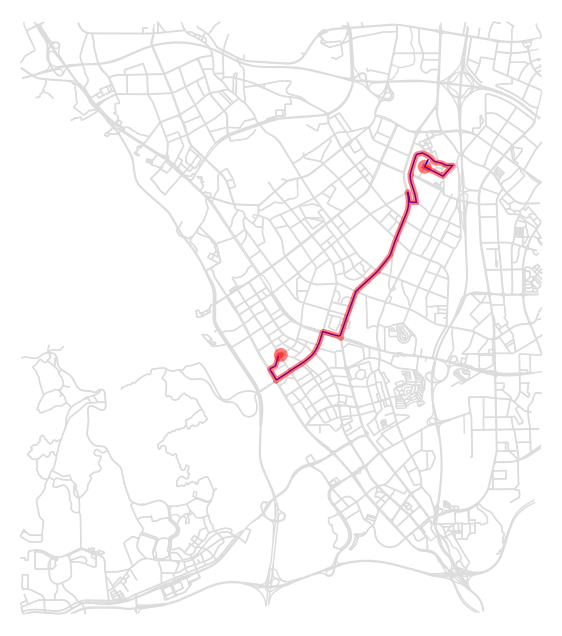

In [13]:
import osmnx as ox
# for i in range(len(traj_nodes)):
#     ans = traj_nodes[i]['xyt']
#     traj_nodes[i]['xyt'] = sorted(ans, key=lambda x: x[-1])
for vid in range(len(list(traj_veh.keys()))):
    if vid != 20:
        continue
    paths = traj_veh[list(traj_veh.keys())[vid]]
    # nodes = np.array(
    #     traj_nodes[1]['xyt'])[:, :1].astype(int).reshape(-1).tolist()
    fig, ax = ox.plot_graph(nx.MultiDiGraph(G2),
                            node_size=0,
                            bgcolor='w',
                            edge_color='#dcdcdc',
                            show=False)
    # for pos in points.tolist():
    #     pos = [pos[0] * scale[0] + offset[0], pos[1] * scale[1] + offset[1]]
    #     ax.scatter(*pos, c='b', s=3)
    coordinates = data[list(traj_veh.keys())[vid]]
    ax.plot([coord[1] for coord in coordinates],
            [coord[0] for coord in coordinates],
            color='blue',
            linewidth=1)
    ox.plot_graph_route(nx.MultiDiGraph(G2),
                        paths,
                        ax=ax,
                        route_colors='g',
                        save=False,
                        bgcolor='w',
                        edge_color='#dcdcdc')
